## Challenge 2: Summarizing Topics with Natural Language Processing

### Import Libraries

In [16]:
import os
import re
import pandas as pd

# pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# Gensim
import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

# WordCloud
from wordcloud import WordCloud, STOPWORDS

# NLTK Stop Words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Matplotlib
import matplotlib.pyplot as plt
import warnings

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anthony\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading Data

In [3]:
# Putting all articles into a list
files = [os.path.join('challenge2-articles', file_name) for file_name in os.listdir('challenge2-articles')]

In [4]:
# Read all articles into a dataframe
articles = pd.DataFrame()
for f in files:
    curr_file = open(f, mode = 'r', encoding = 'utf-8').read()
    articles = pd.concat([articles, pd.DataFrame([[curr_file]])])
articles = articles.reset_index(drop = True)
articles.rename(columns = {0: 'Text'}, inplace = True)

articles.head()

,Text
0,The extensive drain on the body will eventual...
1,The contributions they have made have been in...
2,\n\nThe Eterna Diamonds are considered one of ...
3,. The cure for Pires is the “La La Eterna
4,"\n\nDespite its toxicity, the incense is still..."


### **Approach 1: Word Cloud**

#### I. Preprocessing Text

In [5]:
def sentences_to_words(sentences):
    for s in sentences:
        s = re.sub(r'\s+', ' ', s) # Remove newline characters
        s = re.sub(r"\'", "", s) # Remove single quotes
        s = gensim.utils.simple_preprocess(str(s), deacc = True)
        yield(s)

def process_words(words, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # Initializing bigram and trigram models 
    bigram = gensim.models.Phrases(words, min_count=5, threshold=10) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[words], threshold=10)  
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    words = [[word for word in simple_preprocess(str(w)) if word not in stop_words] for w in words]
    words = [bigram_mod[word] for word in words]
    words = [trigram_mod[bigram_mod[word]] for word in words]
    
    output = []
    nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
    for word in words:
        doc = nlp(" ".join(word))
        output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    
    # Removing stopwords
    output = [[word for word in simple_preprocess(str(w)) if word not in stop_words] for w in output]
    return output
    

In [20]:
warnings.filterwarnings("ignore")
# Break sentences in dataframe into words
analysis_words = list(sentences_to_words(articles['Text'].values))

# Process words, form bigrams, trigrams, lemmatization
processed_words = process_words(analysis_words)

#### II. Making Word Cloud

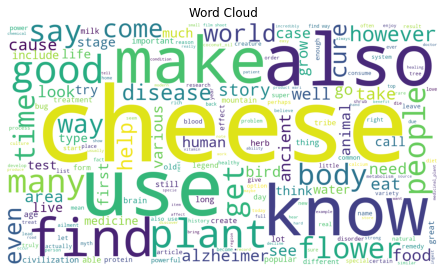

In [19]:
# Setting up wordcloud
wordcloud_words = [y for x in processed_words for y in x]
describe_text = pd.Series(wordcloud_words)
wordcloud = WordCloud(width = 1280, height = 720, stopwords = stop_words, background_color = 'white').generate(' '.join(describe_text))

# Displaying plot
warnings.filterwarnings("ignore")
plt.imshow(wordcloud)
plt.title('Word Cloud')
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()


### **Approach 2: Scikit-learn and Latent Dirichlet Allocation**

Inspired by: https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb#topic=0&lambda=1&term=

#### I. Converting to Document-Term Matrix

In [8]:
%%capture
# Using TfidfVectorizer to fit prediction algorithm using words
tfidf_vectorizer = TfidfVectorizer(strip_accents = 'unicode', stop_words = 'english', lowercase = True,
    token_pattern = r'\b[a-zA-Z]{3,}\b', max_df = 0.5, min_df = 10)
    
dtm_tfidf = tfidf_vectorizer.fit_transform(articles['Text'].values)

#### II. Fitting Latent Dirichlet Allocation (LDA) Models

In [9]:
%%capture
lda_tfidf = LatentDirichletAllocation(n_components = 20)
lda_tfidf.fit(dtm_tfidf)

#### III. Visualizing with pyLDAvis

In [21]:
warnings.filterwarnings("ignore")
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer, mds = 'mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.099957  0.298769       1        1  17.538530
13    -0.053553 -0.326634       2        1  12.323978
11    -0.241850 -0.177328       3        1  10.649692
1     -0.142665  0.243125       4        1   7.242943
0      0.167831 -0.233233       5        1   5.508876
5      0.329282  0.067644       6        1   5.190591
15    -0.003016  0.226849       7        1   4.515717
3     -0.041262 -0.150161       8        1   4.169066
17    -0.150514 -0.104533       9        1   4.118664
19     0.162757  0.073184      10        1   3.649300
8      0.187737 -0.105042      11        1   3.546828
18     0.096648  0.055147      12        1   3.474616
10    -0.262333  0.108490      13        1   2.885591
6      0.019301  0.070332      14        1   2.857721
7      0.031128 -0.107219      15        1   2.617921
4     -0.169063  0.011360      16        1   2.482269
9      0.070582 -0.029750      17        1   2.107794
12    -0.066694  0.086810      18        1   2.001999
2     -0.011913 -0.001917      19        1   1.815508
14    -0.022359 -0.005892      20        1   1.302397, topic_info=      Term       Freq      Total Category  logprob  loglift
19  cheese  14.000000  14.000000  Default  30.0000  30.0000
52    like   5.000000   5.000000  Default  29.0000  29.0000
99   think   3.000000   3.000000  Default  28.0000  28.0000
12     bug   5.000000   5.000000  Default  27.0000  27.0000
48    know   6.000000   6.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
83    rare   0.042735   2.833188  Topic20  -4.7449   0.1468
52    like   0.042735   5.793091  Topic20  -4.7449  -0.5684
76   pires   0.042735   3.472506  Topic20  -4.7449  -0.0566
39   great   0.042735   3.532180  Topic20  -4.7449  -0.0737
44   human   0.042735   3.092579  Topic20  -4.7449   0.0592

[822 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         2  0.354915      able
0        10  0.354915      able
1         2  0.407979  actually
2         3  0.495159  ailments
3         3  0.437394   america
...     ...       ...       ...
113       4  0.198698     world
113       7  0.198698     world
113      15  0.198698     world
114       3  0.349536     years
114       4  0.349536     years

[203 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 14, 12, 2, 1, 6, 16, 4, 18, 20, 9, 19, 11, 7, 8, 5, 10, 13, 3, 15])